# House Prices Prediction

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [38]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [3]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.19.0
TensorFlow Decision Forests v1.12.0


## Load the dataset


In [4]:
train_file = "train.csv"
train_df = pd.read_csv(train_file)
print("Full train dataset shape is {}".format(train_df.shape))

Full train dataset shape is (1460, 81)


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [5]:
train_df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

In [6]:
train_df = train_df.drop('Id', axis=1)
train_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


We can inspect the types of feature columns using the following code:

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [8]:
print("Types of data:\n")
print(train_df.dtypes.value_counts())

Types of data:

object     43
int64      34
float64     3
Name: count, dtype: int64


## House Price Distribution

Now let us take a look at how the house prices are distributed.

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_11374/1859412649.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


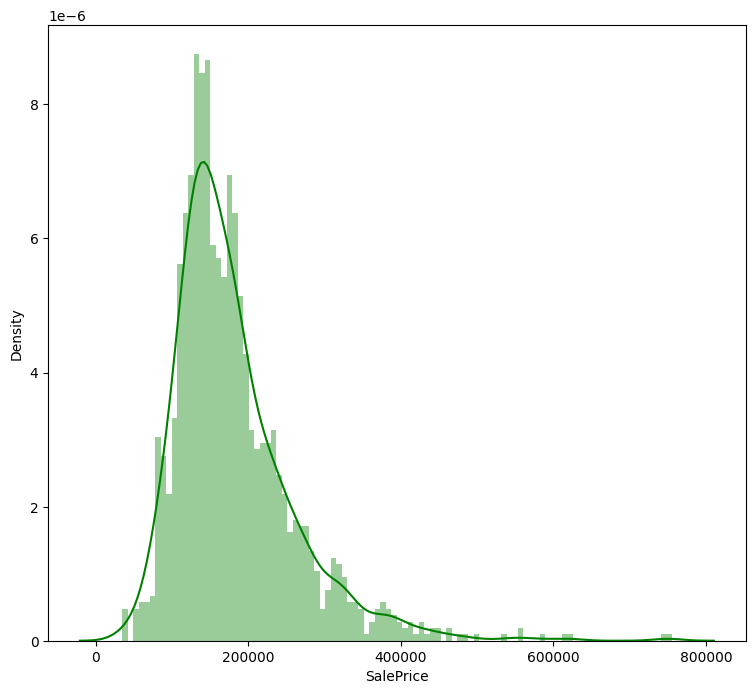

In [9]:
print(train_df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [10]:
list(set(train_df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [11]:
df_num = train_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


Now let us plot the distribution for all the numerical features.

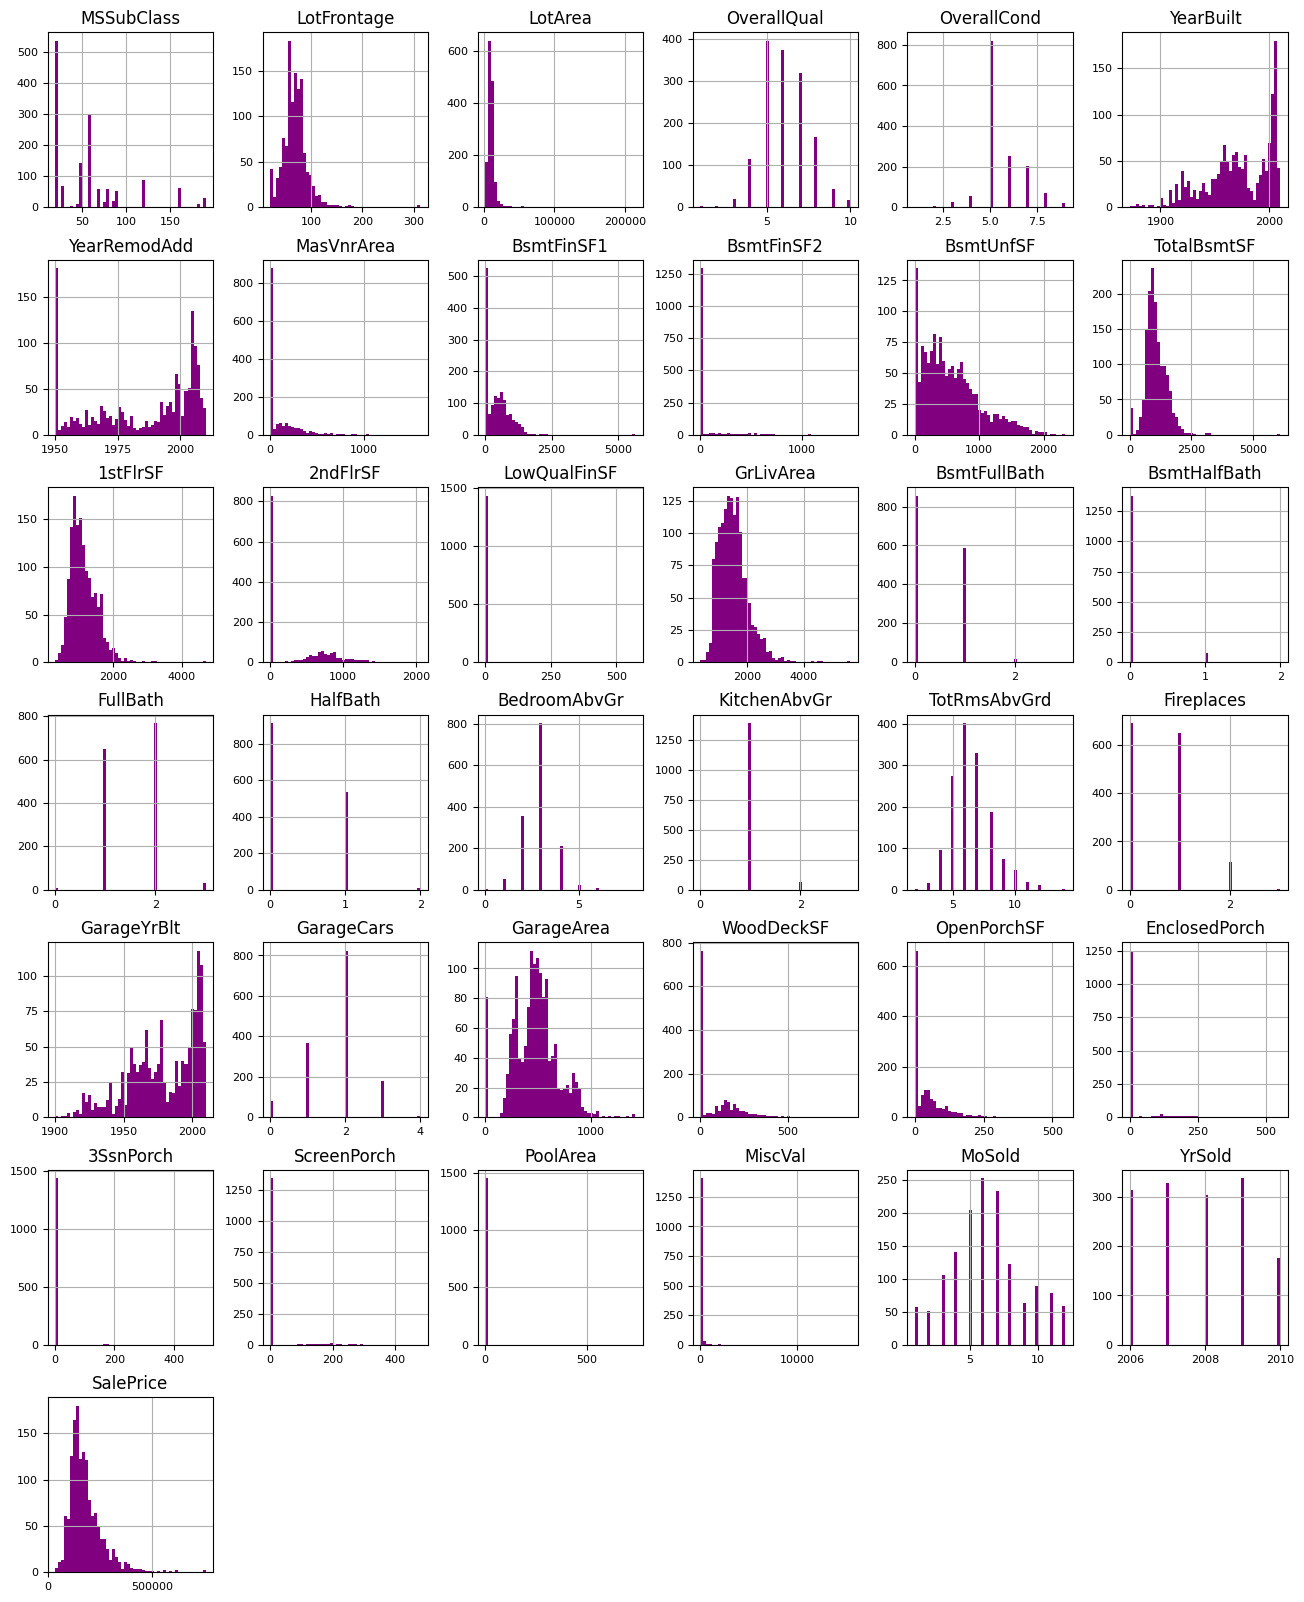

In [12]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8, color= 'purple');

## Missing Values

In [13]:
print("Missing values in each column")
missing_data = train_df.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Missing values in each column
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


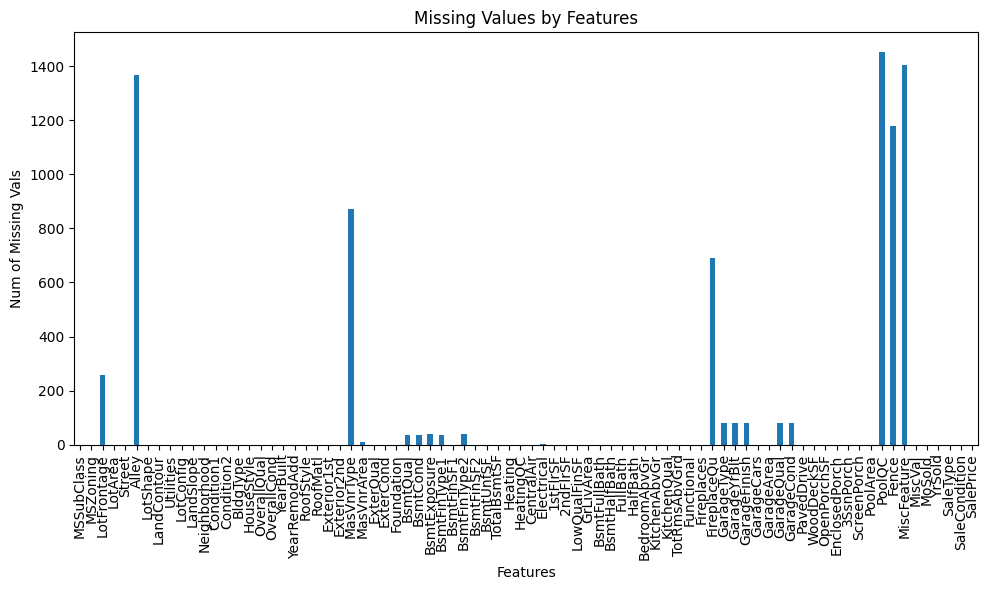

In [14]:
# Visualizing the missing values

plt.figure(figsize=(10, 6))
missing_data.plot(kind="bar")
plt.title("Missing Values by Features")
plt.xlabel("Features")
plt.ylabel("Num of Missing Vals")
plt.tight_layout()
plt.show()

## Corelation With SalePrice

In [15]:
# Finding coorelation between numerical features (int & float) with target feature (SalePrice)
numerical_features = train_df.select_dtypes(include= [np.number]).columns.tolist()

correlation = train_df[numerical_features].corr()['SalePrice'].sort_values(ascending=False)
print(f"Top 10 correlated features:\n{correlation.head(10)}")

Top 10 correlated features:
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64


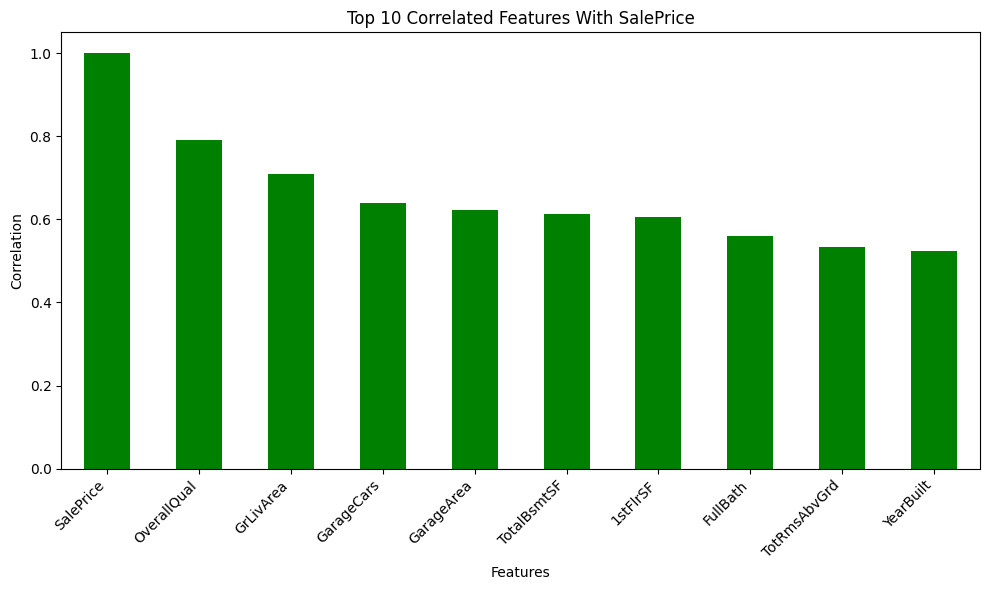

In [16]:
# Visualizing the correlation features with SalePrice

plt.figure(figsize=(10, 6))
correlation.head(10).plot(kind="bar", color= 'green')
plt.title("Top 10 Correlated Features With SalePrice")
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Correlation")
plt.tight_layout()
plt.show()

## Data Cleaning And Preprocessing

In [17]:
def preprocess_data(df, is_training = False):

    # Features where NA means 'None' that's not missing
    none_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                     'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'MasVnrType']
    
    # Filling the NA values with "None"
    for feature in none_features:
        if feature in df.columns:
            df[feature] = df[feature].fillna('None')

    # Filling missing data in MasVnrType with None
    if 'MasVnrType' in df.columns:
        df['MasVnrType'] = df['MasVnrType'].fillna('None')

    # Filling LotsFrontage missing data with median
    if 'LotFrontage' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        # If still missing, uses overall median
        df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    
    # Filling GarageYrBlt missing data with YearBuilt
    if 'GarageYrBlt' in df.columns and 'YearBuilt' in df.columns:
        df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
    
    # Filling Electrical missing data with modal value
    if 'Electrical' in df.columns:
        df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0] if len(df['Electrical'].mode()) > 0 else 'SBrkr')

    # Filling missing data in MasVnrArea with 0
    if 'MasVnrArea' in df.columns:
        df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

    # Converting quality ratings to numeric value
    quality_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'KitchenQual']
    quality_map = {
        "Ex": 5,
        "Gd": 4,
        "TA": 3,
        "Fa": 2,
        "Po": 1,
        "None": 0
    }
    
    for feature in quality_features:
        if feature in df.columns:
            df[f'{feature}_num'] = df[feature].map(quality_map).fillna(0).astype(int)

    # Feature Engineering
    
    # Total square footage
    if all(col in df.columns for col in ['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF']):
        df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
    
    # Total porch area
    porch_cols = ['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
    if all(col in df.columns for col in porch_cols):
        df['TotalPorchSF'] = df[porch_cols].sum(axis=1)
    
    # Age-related features
    if all(col in df.columns for col in ['YrSold', 'YearBuilt', 'YearRemodAdd']):
        df['HouseAge'] = df['YrSold'] - df['YearBuilt']
        df['YearsSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
    
    # Total bathrooms
    bath_cols = ['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath']
    if all(col in df.columns for col in bath_cols):
        df['TotalBath'] = df['FullBath'] + 0.5 * df['HalfBath'] + df['BsmtFullBath'] + 0.5 * df['BsmtHalfBath']

    # Handling skewed features with log transformation
    skewed_features = ['MiscVal', 'PoolArea', 'LotArea', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2', 'ScreenPorch']
    
    for feature in skewed_features:
        if feature in df.columns:
            # Only log transform if all values are non-negative
            if (df[feature] >= 0).all():
                df[f'{feature}_log'] = np.log1p(df[feature])

    # Handling SalePrice for training data (log transformation)
    if is_training and 'SalePrice' in df.columns:
        df['SalePrice_log'] = np.log1p(df['SalePrice'])
    
    return df

In [18]:
#  Preprocessing training dataset

train_processed = preprocess_data(train_df, is_training=True)

In [19]:
# Processed dataset info for comparison

train_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 98 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MSSubClass        1460 non-null   int64  
 1   MSZoning          1460 non-null   object 
 2   LotFrontage       1460 non-null   float64
 3   LotArea           1460 non-null   int64  
 4   Street            1460 non-null   object 
 5   Alley             1460 non-null   object 
 6   LotShape          1460 non-null   object 
 7   LandContour       1460 non-null   object 
 8   Utilities         1460 non-null   object 
 9   LotConfig         1460 non-null   object 
 10  LandSlope         1460 non-null   object 
 11  Neighborhood      1460 non-null   object 
 12  Condition1        1460 non-null   object 
 13  Condition2        1460 non-null   object 
 14  BldgType          1460 non-null   object 
 15  HouseStyle        1460 non-null   object 
 16  OverallQual       1460 non-null   int64  


In [20]:
# Revising missing data in each column for the processed dataset

missing_data = train_processed.isnull().sum()
print(missing_data[missing_data > 0].sort_values(ascending=False))

Series([], dtype: int64)


<Axes: xlabel='TotalPorchSF', ylabel='SalePrice'>

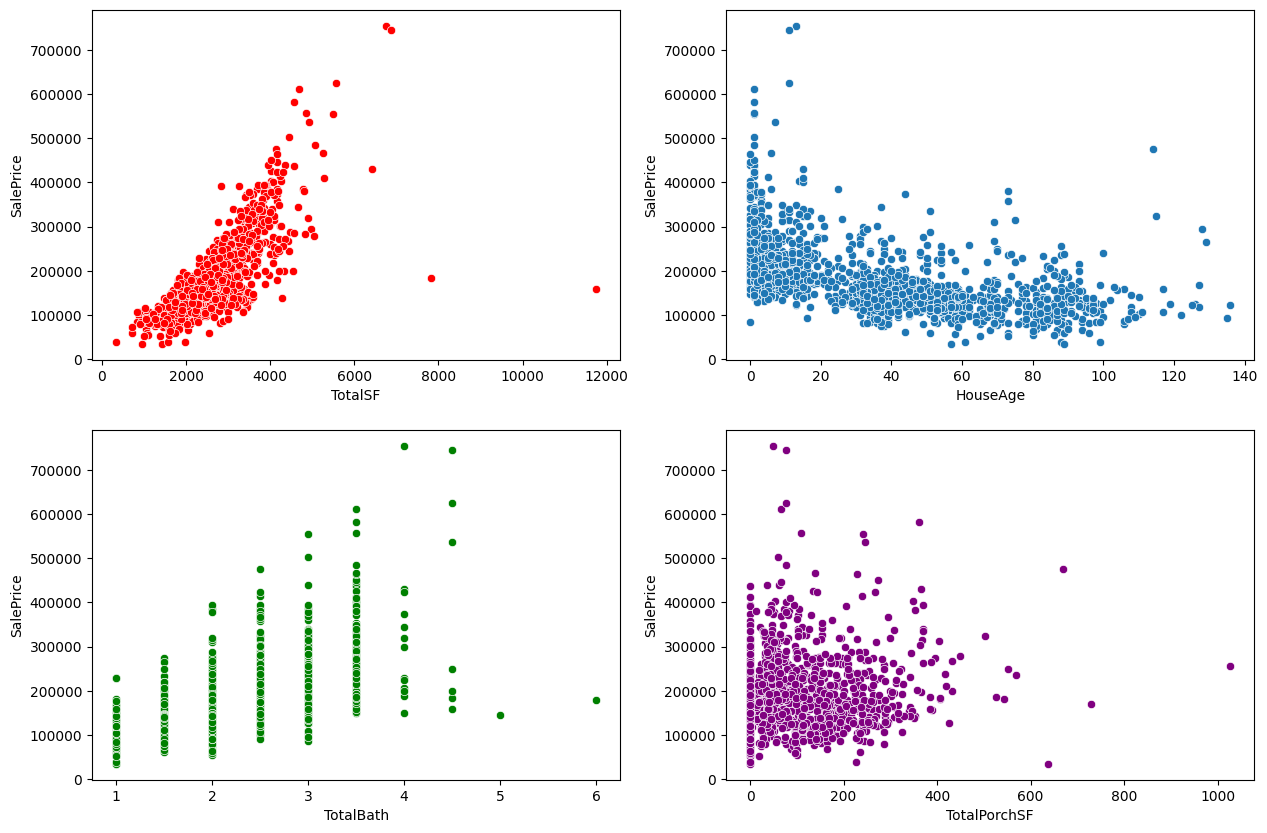

In [21]:
# Visualizing new features vs target feature using scatter plot

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.scatterplot(data=train_df, x='TotalSF', y='SalePrice', ax=axes[0,0], color= "red")
sns.scatterplot(data=train_df, x='HouseAge', y='SalePrice', ax=axes[0,1])
sns.scatterplot(data=train_df, x='TotalBath', y='SalePrice', ax=axes[1,0], color= "green")
sns.scatterplot(data=train_df, x='TotalPorchSF', y='SalePrice', ax=axes[1,1], color= "purple")

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [22]:
# Function for train-test-split (80:20)

def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_processed)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1173 examples in training, 287 examples in testing.


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [23]:
# To avoid TensorFlow CUDA error

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [25]:
# Converting pandas dataframe to TensorFlow datasets

label = 'SalePrice_log'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [26]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [30]:
# Random Forest model
rf = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,
    num_trees=300,
    max_depth=16,
    min_examples=5,
    verbose=2
)

# Selecting Mean Squared Error as evaluation metric
rf.compile(metrics=["mse"])

Use 16 thread(s) for training
Use /tmp/tmpnqokcms2 as temporary training directory


## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [31]:
# Train the model
print("\nTraining the Random Forest model...")
rf.fit(x=train_ds, validation_data=valid_ds)


Training the Random Forest model...
Reading training dataset...
Training tensor examples:
Features: {'MSSubClass': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'MSZoning': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'LotFrontage': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'LotArea': <tf.Tensor 'data_3:0' shape=(None,) dtype=int64>, 'Street': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>, 'Alley': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'LotShape': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'LandContour': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'Utilities': <tf.Tensor 'data_8:0' shape=(None,) dtype=string>, 'LotConfig': <tf.Tensor 'data_9:0' shape=(None,) dtype=string>, 'LandSlope': <tf.Tensor 'data_10:0' shape=(None,) dtype=string>, 'Neighborhood': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'Condition1': <tf.Tensor 'data_12:0' shape=(None,) dtype=string>, 'Condition2': <tf.Tensor 'data_13:0' shape=(None,) dtype=string>, 'B

## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [32]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

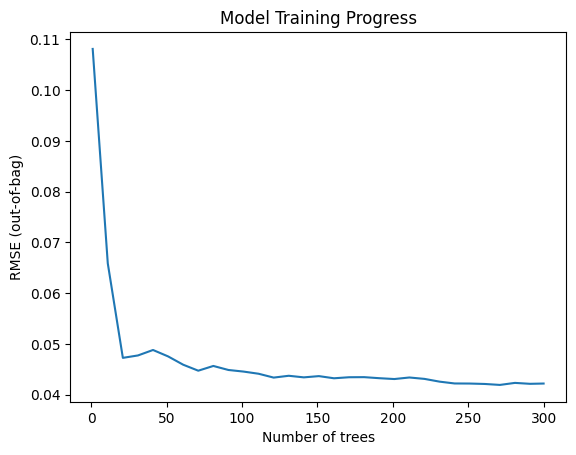

In [33]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.title("Model Training Progress")
plt.show()

We can also see some general stats on the OOB dataset:

In [34]:
inspector = rf.make_inspector()
print("OOB Evaluation:", inspector.evaluation())

OOB Evaluation: Evaluation(num_examples=1173, accuracy=None, loss=None, rmse=0.042176772479444145, ndcg=None, aucs=None, auuc=None, qini=None)


Now, let us run an evaluation using the validation dataset.

In [35]:
print("\nEvaluating the RF model...")
evaluation = rf.evaluate(x=valid_ds, return_dict=True)
print(f"Validation MSE: {evaluation['mse']:.4f}")


Evaluating the RF model...
1/1 [==============================] - 0s 147ms/step - loss: 0.0000e+00 - mse: 0.0016
Validation MSE: 0.0016


In [39]:
# Calculates RMSE
valid_predictions_log = rf.predict(valid_ds)
valid_actual_log = valid_ds_pd[label].values

# Transform back from log scale
valid_predictions = np.expm1(valid_predictions_log.flatten())
valid_actual = np.expm1(valid_actual_log)
rmse = np.sqrt(mean_squared_error(valid_actual, valid_predictions))
print(f"Validation RMSE (original scale): ${rmse:,.2f}")

1/1 [==============================] - 0s 106ms/step
Validation RMSE (original scale): $3,947.00


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [40]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [41]:
# Top 10 important features

inspector = rf.make_inspector()
print("\nTop 10 Most Important Features:")
for feature, importance in inspector.variable_importances()["NUM_AS_ROOT"][:10]:
    print(f"{feature.name}: {importance}")


Top 10 Most Important Features:
SalePrice: 106.0
OverallQual: 66.0
TotalSF: 49.0
ExterQual: 24.0
Neighborhood: 19.0
ExterQual_num: 14.0
YearBuilt: 7.0
HouseAge: 5.0
KitchenQual: 3.0
GrLivArea: 2.0


Plot the variable importances from the inspector using Matplotlib

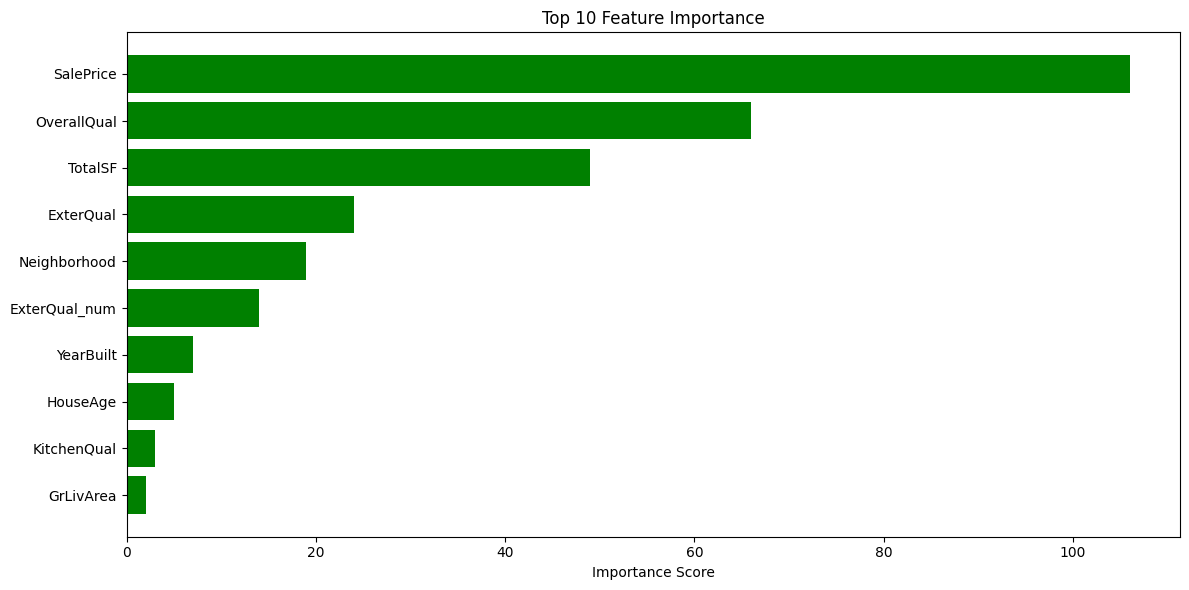

In [42]:
# Plotting feature importance

plt.figure(figsize=(12, 6))
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extracting feature names and importance values

feature_names = [vi[0].name for vi in variable_importances[:10]]  # Top 10
feature_importances = [vi[1] for vi in variable_importances[:10]]

# Creating horizontal bar plot

plt.barh(range(len(feature_names)), feature_importances, color = 'green')
plt.yticks(range(len(feature_names)), feature_names)
plt.gca().invert_yaxis()
plt.xlabel("Importance Score")
plt.title("Top 10 Feature Importance")
plt.tight_layout()
plt.show()

# Submission
Finally predict on the competition test data using the model.

In [44]:
# Initializing test dataset

test_file_path = "test.csv"
test_df = pd.read_csv(test_file_path)
print(f"Test dataset shape: {test_df.shape}")

# Dropping ID column from test dataset
test_df = test_df.drop('Id', axis=1)

Test dataset shape: (1459, 80)


## Preprocessing the testing dataset similar to the training dataset

In [45]:
# Preprocess test dataset

test_processed = preprocess_data(test_df, is_training=False)

# Checking the size of both datasets to avoid errors
print(f"Training data shape after preprocessing: {train_processed.shape}")
print(f"Test data shape after preprocessing: {test_processed.shape}")

Training data shape after preprocessing: (1460, 98)
Test data shape after preprocessing: (1459, 95)


In [46]:
# Checking for remaining missing values in test dataset

print("\nMissing values in test data:")
print(test_processed.isnull().sum()[test_processed.isnull().sum() > 0])


Missing values in test data:
MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
SaleType        1
TotalSF         1
TotalBath       2
dtype: int64


In [47]:
# Make predictions on test data

print("\nMaking predictions on test data...")

train_features = set(train_ds_pd.columns) - {label, 'SalePrice'}
test_features = set(test_processed.columns)


Making predictions on test data...


In [48]:
# Add missing features with default values
missing_features = train_features - test_features
for feature in missing_features:
    test_processed[feature] = 0
    print(f"Added missing feature '{feature}' with default value 0")

# Remove extra features not in training
extra_features = test_features - train_features
for feature in extra_features:
    if feature in test_processed.columns:
        test_processed = test_processed.drop(feature, axis=1)
        print(f"Removed extra feature '{feature}'")

Added missing feature 'BsmtFinSF2_log' with default value 0


In [49]:
# Create test dataset
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_df,
    task = tfdf.keras.Task.REGRESSION)

# Generating predictions
test_predictions_log = rf.predict(test_ds)
test_predictions = np.expm1(test_predictions_log.flatten())

ValueError: in user code:

    File "/home/fy-g15/Documents/house-sales-price-prediction/ml_env/lib/python3.12/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 486, in run_step  *
        outputs = model.predict_step(data)
    File "/home/fy-g15/Documents/house-sales-price-prediction/ml_env/lib/python3.12/site-packages/tf_keras/src/engine/training.py", line 2377, in predict_step  **
        return self(x, training=False)
    File "/home/fy-g15/Documents/house-sales-price-prediction/ml_env/lib/python3.12/site-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filemztyo0ma.py", line 232, in tf__call
        ag__.if_stmt(ag__.ld(self)._semantics is None, if_body_8, else_body_8, get_state_11, set_state_11, ('do_return', 'retval_'), 2)
    File "/tmp/__autograph_generated_filemztyo0ma.py", line 43, in else_body_8
        normalized_inputs = ag__.converted_call(ag__.ld(self)._build_normalized_inputs, (ag__.ld(inputs),), None, fscope)
    File "/tmp/__autograph_generated_filei467cazb.py", line 98, in tf___build_normalized_inputs
        semantic_inputs = ag__.converted_call(ag__.ld(tf_core).combine_tensors_and_semantics, (ag__.ld(inputs), ag__.ld(self)._semantics), None, fscope)
    File "/tmp/__autograph_generated_filemh528l2k.py", line 34, in tf__combine_tensors_and_semantics
        ag__.if_stmt(ag__.not_(ag__.converted_call(ag__.converted_call(ag__.ld(set), (ag__.converted_call(ag__.ld(semantics).keys, (), None, fscope),), None, fscope).issubset, (ag__.converted_call(ag__.ld(inputs).keys, (), None, fscope),), None, fscope)), if_body, else_body, get_state, set_state, (), 0)
    File "/tmp/__autograph_generated_filemh528l2k.py", line 30, in if_body
        raise ag__.converted_call(ag__.ld(ValueError), (ag__.converted_call('semantics is not a subset of inputs (inputs={} vs semantics={}).'.format, (ag__.converted_call(ag__.ld(inputs).keys, (), None, fscope), ag__.converted_call(ag__.ld(semantics).keys, (), None, fscope)), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'random_forest_model' (type RandomForestModel).
    
    in user code:
    
        File "/home/fy-g15/Documents/house-sales-price-prediction/ml_env/lib/python3.12/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 672, in call  *
            normalized_inputs = self._build_normalized_inputs(inputs)
        File "/home/fy-g15/Documents/house-sales-price-prediction/ml_env/lib/python3.12/site-packages/tensorflow_decision_forests/keras/core_inference.py", line 631, in _build_normalized_inputs  *
            semantic_inputs = tf_core.combine_tensors_and_semantics(
        File "/home/fy-g15/Documents/house-sales-price-prediction/ml_env/lib/python3.12/site-packages/tensorflow_decision_forests/tensorflow/core_inference.py", line 431, in combine_tensors_and_semantics  *
            raise ValueError("semantics is not a subset of inputs "
    
        ValueError: semantics is not a subset of inputs (inputs=dict_keys(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'ExterQual_num', 'ExterCond_num', 'BsmtQual_num', 'BsmtCond_num', 'KitchenQual_num', 'TotalSF', 'TotalPorchSF', 'HouseAge', 'YearsSinceRemod', 'TotalBath', 'MiscVal_log', 'PoolArea_log', 'LotArea_log', '3SsnPorch_log', 'LowQualFinSF_log', 'ScreenPorch_log', 'BsmtFinSF2_log']) vs semantics=dict_keys(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'ExterQual_num', 'ExterCond_num', 'BsmtQual_num', 'BsmtCond_num', 'KitchenQual_num', 'TotalSF', 'TotalPorchSF', 'HouseAge', 'YearsSinceRemod', 'TotalBath', 'MiscVal_log', 'PoolArea_log', 'LotArea_log', '3SsnPorch_log', 'LowQualFinSF_log', 'BsmtFinSF2_log', 'ScreenPorch_log'])).
    
    
    Call arguments received by layer 'random_forest_model' (type RandomForestModel):
      • inputs={'MSSubClass': 'tf.Tensor(shape=(None,), dtype=int64)', 'MSZoning': 'tf.Tensor(shape=(None,), dtype=string)', 'LotFrontage': 'tf.Tensor(shape=(None,), dtype=float32)', 'LotArea': 'tf.Tensor(shape=(None,), dtype=int64)', 'Street': 'tf.Tensor(shape=(None,), dtype=string)', 'Alley': 'tf.Tensor(shape=(None,), dtype=string)', 'LotShape': 'tf.Tensor(shape=(None,), dtype=string)', 'LandContour': 'tf.Tensor(shape=(None,), dtype=string)', 'Utilities': 'tf.Tensor(shape=(None,), dtype=string)', 'LotConfig': 'tf.Tensor(shape=(None,), dtype=string)', 'LandSlope': 'tf.Tensor(shape=(None,), dtype=string)', 'Neighborhood': 'tf.Tensor(shape=(None,), dtype=string)', 'Condition1': 'tf.Tensor(shape=(None,), dtype=string)', 'Condition2': 'tf.Tensor(shape=(None,), dtype=string)', 'BldgType': 'tf.Tensor(shape=(None,), dtype=string)', 'HouseStyle': 'tf.Tensor(shape=(None,), dtype=string)', 'OverallQual': 'tf.Tensor(shape=(None,), dtype=int64)', 'OverallCond': 'tf.Tensor(shape=(None,), dtype=int64)', 'YearBuilt': 'tf.Tensor(shape=(None,), dtype=int64)', 'YearRemodAdd': 'tf.Tensor(shape=(None,), dtype=int64)', 'RoofStyle': 'tf.Tensor(shape=(None,), dtype=string)', 'RoofMatl': 'tf.Tensor(shape=(None,), dtype=string)', 'Exterior1st': 'tf.Tensor(shape=(None,), dtype=string)', 'Exterior2nd': 'tf.Tensor(shape=(None,), dtype=string)', 'MasVnrType': 'tf.Tensor(shape=(None,), dtype=string)', 'MasVnrArea': 'tf.Tensor(shape=(None,), dtype=float32)', 'ExterQual': 'tf.Tensor(shape=(None,), dtype=string)', 'ExterCond': 'tf.Tensor(shape=(None,), dtype=string)', 'Foundation': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtQual': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtCond': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtExposure': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtFinType1': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtFinSF1': 'tf.Tensor(shape=(None,), dtype=float32)', 'BsmtFinType2': 'tf.Tensor(shape=(None,), dtype=string)', 'BsmtFinSF2': 'tf.Tensor(shape=(None,), dtype=float32)', 'BsmtUnfSF': 'tf.Tensor(shape=(None,), dtype=float32)', 'TotalBsmtSF': 'tf.Tensor(shape=(None,), dtype=float32)', 'Heating': 'tf.Tensor(shape=(None,), dtype=string)', 'HeatingQC': 'tf.Tensor(shape=(None,), dtype=string)', 'CentralAir': 'tf.Tensor(shape=(None,), dtype=string)', 'Electrical': 'tf.Tensor(shape=(None,), dtype=string)', '1stFlrSF': 'tf.Tensor(shape=(None,), dtype=int64)', '2ndFlrSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'LowQualFinSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'GrLivArea': 'tf.Tensor(shape=(None,), dtype=int64)', 'BsmtFullBath': 'tf.Tensor(shape=(None,), dtype=float32)', 'BsmtHalfBath': 'tf.Tensor(shape=(None,), dtype=float32)', 'FullBath': 'tf.Tensor(shape=(None,), dtype=int64)', 'HalfBath': 'tf.Tensor(shape=(None,), dtype=int64)', 'BedroomAbvGr': 'tf.Tensor(shape=(None,), dtype=int64)', 'KitchenAbvGr': 'tf.Tensor(shape=(None,), dtype=int64)', 'KitchenQual': 'tf.Tensor(shape=(None,), dtype=string)', 'TotRmsAbvGrd': 'tf.Tensor(shape=(None,), dtype=int64)', 'Functional': 'tf.Tensor(shape=(None,), dtype=string)', 'Fireplaces': 'tf.Tensor(shape=(None,), dtype=int64)', 'FireplaceQu': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageType': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageYrBlt': 'tf.Tensor(shape=(None,), dtype=float32)', 'GarageFinish': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageCars': 'tf.Tensor(shape=(None,), dtype=float32)', 'GarageArea': 'tf.Tensor(shape=(None,), dtype=float32)', 'GarageQual': 'tf.Tensor(shape=(None,), dtype=string)', 'GarageCond': 'tf.Tensor(shape=(None,), dtype=string)', 'PavedDrive': 'tf.Tensor(shape=(None,), dtype=string)', 'WoodDeckSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'OpenPorchSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'EnclosedPorch': 'tf.Tensor(shape=(None,), dtype=int64)', '3SsnPorch': 'tf.Tensor(shape=(None,), dtype=int64)', 'ScreenPorch': 'tf.Tensor(shape=(None,), dtype=int64)', 'PoolArea': 'tf.Tensor(shape=(None,), dtype=int64)', 'PoolQC': 'tf.Tensor(shape=(None,), dtype=string)', 'Fence': 'tf.Tensor(shape=(None,), dtype=string)', 'MiscFeature': 'tf.Tensor(shape=(None,), dtype=string)', 'MiscVal': 'tf.Tensor(shape=(None,), dtype=int64)', 'MoSold': 'tf.Tensor(shape=(None,), dtype=int64)', 'YrSold': 'tf.Tensor(shape=(None,), dtype=int64)', 'SaleType': 'tf.Tensor(shape=(None,), dtype=string)', 'SaleCondition': 'tf.Tensor(shape=(None,), dtype=string)', 'ExterQual_num': 'tf.Tensor(shape=(None,), dtype=int64)', 'ExterCond_num': 'tf.Tensor(shape=(None,), dtype=int64)', 'BsmtQual_num': 'tf.Tensor(shape=(None,), dtype=int64)', 'BsmtCond_num': 'tf.Tensor(shape=(None,), dtype=int64)', 'KitchenQual_num': 'tf.Tensor(shape=(None,), dtype=int64)', 'TotalSF': 'tf.Tensor(shape=(None,), dtype=float32)', 'TotalPorchSF': 'tf.Tensor(shape=(None,), dtype=int64)', 'HouseAge': 'tf.Tensor(shape=(None,), dtype=int64)', 'YearsSinceRemod': 'tf.Tensor(shape=(None,), dtype=int64)', 'TotalBath': 'tf.Tensor(shape=(None,), dtype=float32)', 'MiscVal_log': 'tf.Tensor(shape=(None,), dtype=float32)', 'PoolArea_log': 'tf.Tensor(shape=(None,), dtype=float32)', 'LotArea_log': 'tf.Tensor(shape=(None,), dtype=float32)', '3SsnPorch_log': 'tf.Tensor(shape=(None,), dtype=float32)', 'LowQualFinSF_log': 'tf.Tensor(shape=(None,), dtype=float32)', 'ScreenPorch_log': 'tf.Tensor(shape=(None,), dtype=float32)', 'BsmtFinSF2_log': 'tf.Tensor(shape=(None,), dtype=int64)'}
      • training=False


In [ ]:
# Creating submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': test_predictions
})

In [ ]:
submission.to_csv('house_prices_submission.csv', index=False)
print("Predictions saved to 'house_prices_submission.csv'")
print(f"Prediction statistics:")
print(f"Mean: ${test_predictions.mean():,.2f}")
print(f"Median: ${np.median(test_predictions):,.2f}")
print(f"Min: ${test_predictions.min():,.2f}")
print(f"Max: ${test_predictions.max():,.2f}")

## Visualization

In [ ]:
# Visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Actual vs Predicted (validation set)
plt.subplot(1, 3, 1)
plt.scatter(valid_actual, valid_predictions, alpha=0.5)
plt.plot([valid_actual.min(), valid_actual.max()], 
         [valid_actual.min(), valid_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (Validation)')

# Plot 2: Residuals
plt.subplot(1, 3, 2)
residuals = valid_predictions - valid_actual
plt.scatter(valid_predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Plot 3: Prediction distribution
plt.subplot(1, 3, 3)
plt.hist(test_predictions, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Predicted Price')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Prices')

plt.tight_layout()
plt.show()